# MileStone 2 - Automatic Ticket Classifier



**Importing neccessary libraries**


In [1]:
# Import packages
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style
 
import random, re
assert tf.__version__ >= '2.0'
%matplotlib inline

# Set random state
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

In [2]:
#importing the training data
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'


**Importing Data and viewing the top 5 and bottom 5 records**

In [4]:
import os; os.chdir('/content/drive/My Drive/')
data = pd.read_excel('input_data.xlsx')
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. Here are the first five rows of the data...')
display(data.head())

Data has 8500 rows and 4 columns. Here are the first five rows of the data...


,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [5]:
data.tail()

,Short description,Description,Caller,Assignment group
8495,emails not coming in from zz mail,\r\n\r\nreceived from: avglmrts.vhqmtiua@gmail...,avglmrts vhqmtiua,GRP_29
8496,telephony_software issue,telephony_software issue,rbozivdq gmlhrtvp,GRP_0
8497,vip2: windows password reset for tifpdchb pedx...,vip2: windows password reset for tifpdchb pedx...,oybwdsgx oxyhwrfz,GRP_0
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62
8499,an mehreren pc`s lassen sich verschiedene prgr...,an mehreren pc`s lassen sich verschiedene prgr...,kqvbrspl jyzoklfx,GRP_49


**Checking the columns in Dataset**

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [7]:
# Describe the dataset with various summary and statistics
data.describe()

,Short description,Description,Caller,Assignment group
count,8492,8499,8500,8500
unique,7481,7817,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976


**Checking for null values**

In [8]:
#null value counts in each column
data.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [9]:
# NULL values are updated with space
data.fillna(str(), inplace=True)
data[pd.isnull(data).any(axis=1)]

,Short description,Description,Caller,Assignment group


**Mojibake Correction**

In [10]:
!pip install ftfy

     |████████████████████████████████| 71kB 9.4MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41935 sha256=595be2651e3b34943a2aa7e49b081ecb8491a20e35b843797b0482f0782f42c7
  Stored in directory: /root/.cache/pip/wheels/99/2c/e6/109c8a28fef7a443f67ba58df21fe1d0067ac3322e75e6b0b7
Successfully built ftfy


In [11]:
from ftfy import fix_encoding, fix_text, badness
# detect Mojibakes
def mojibake_present(text):
    if not badness.sequence_weirdness(text):
        return True
    try:
        text.encode('sloppy-windows-1252')
    except UnicodeEncodeError:
        return True
    else:
        return False
    
# Check the dataset for mojibake impact
data[~data.iloc[:,:-1].applymap(mojibake_present).all(1)]

,Short description,Description,Caller,Assignment group
99,password expiry tomorrow,\n\nreceived from: ecprjbod.litmjwsy@gmail.com...,ecprjbod litmjwsy,GRP_0
116,server issues,\r\n\r\nreceived from: bgqpotek.cuxakvml@gmail...,bgqpotek cuxakvml,GRP_0
124,mobile device activation,"from: tvcdfqgp nrbcqwgj \nsent: friday, octobe...",tvcdfqgp nrbcqwgj,GRP_0
162,access to bex,\r\n\r\nreceived from: yfqoaepn.xnezhsit@gmail...,yfqoaepn xnezhsit,GRP_0
164,æ’¤å›ž: ticket_no1564867 -- comments added,\n\nreceived from: abcdri@company.com\n\nwindy...,tycludks cjofwigv,GRP_0
...,...,...,...,...
8470,please review your recent ticketing_tool ticke...,"from: mikhghytr wafglhdrhjop \nsent: thursday,...",azxhejvq fyemlavd,GRP_16
8471,ç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥,to å°è´ºï¼Œæ—©ä¸Šç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥,xqyjztnm onfusvlz,GRP_30
8480,customer group enhanced field,\r\n\r\nreceived from: nlearzwi.ukdzstwi@gmail...,nlearzwi ukdzstwi,GRP_9
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62


**Language Detection**

In [12]:
!pip install langdetect

     |████████████████████████████████| 983kB 29.4MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993242 sha256=fb76d02c3ff8fb6b3627025758fd8533ad4edd9de2ecfe4657685d006be84d42
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7ddc6c92d3aa015cf1a498df5a70268996
Successfully built langdetect


In [13]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(data))):
    # split by space into list, take the first x intex, join with space
    text = data.iloc[ii]['Short description'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
   
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
      
        except Exception as e:
            
            try:
      
                lang = detect(data.iloc[ii]['Description'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 8500/8500 [01:23<00:00, 101.45it/s]


In [14]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 8500

{'af': 500,
 'ca': 129,
 'cs': 8,
 'cy': 24,
 'da': 124,
 'de': 397,
 'en': 5979,
 'es': 95,
 'et': 17,
 'fi': 11,
 'fr': 279,
 'hr': 6,
 'id': 15,
 'it': 266,
 'lt': 8,
 'lv': 7,
 'nl': 146,
 'no': 174,
 'pl': 51,
 'pt': 34,
 'ro': 35,
 'sk': 12,
 'sl': 19,
 'so': 4,
 'sq': 18,
 'sv': 103,
 'sw': 1,
 'tl': 25,
 'tr': 10,
 'vi': 3}


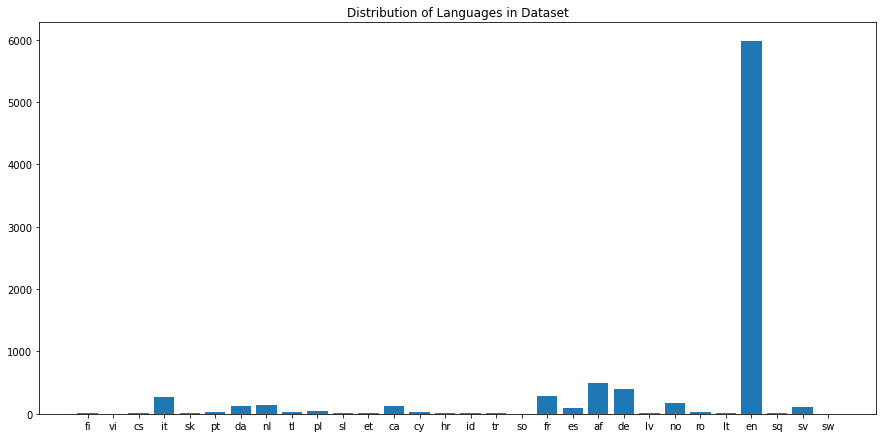

In [15]:
data['language'] = languages
plt.figure(figsize = (15 , 7.2))
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

4 B] Treating other Data Inconsistencies

Text Preprocessing

Text preprocessing is the process of transferring text from human language to machine-readable format for further processing. After a text was obtained, text normalization was taken into consideration.Text normalization included:

converting all letters to lower or upper case
converting numbers into words or removing numbers
removing punctuations, accent marks and other diacritics
removing white spaces
removing stop words, sparse terms, and particular words

In [16]:
# Before removing caller email it was observed that there was a similar string  present in description, so that was needed to clean first
data_df = data.copy()
data_df['Caller email'] = data_df.apply(lambda x: x['Caller'].replace(' ', '.'), axis=1)
data_df['Caller email'] = data_df.apply(lambda x: x['Caller email'] + '@gmail.com', axis=1)
data_df.head(10)

,Short description,Description,Caller,Assignment group,language,Caller email
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,en,spxjnwir.pjlcoqds@gmail.com
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,af,hmjdrvpb.komuaywn@gmail.com
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,en,eylqgodm.ybqkwiam@gmail.com
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,en,xbkucsvz.gcpydteq@gmail.com
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,no,owlgqjme.qhcozdfx@gmail.com
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0,en,eflahbxn.ltdgrvkz@gmail.com
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1,en,jyoqwxhz.clhxsoqy@gmail.com
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0,en,eqzibjhw.ymebpoih@gmail.com
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0,en,mdbegvct.dbvichlg@gmail.com
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0,en,fumkcsji.sarmtlhy@gmail.com


In [17]:
# Replacing Caller email id in Description column by ''
data_df['Description']=data_df.apply(lambda x: x['Description'].replace(x['Caller email'], ''), axis=1)
data_df.head(10)

,Short description,Description,Caller,Assignment group,language,Caller email
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,en,spxjnwir.pjlcoqds@gmail.com
1,outlook,"\r\n\r\nreceived from: \r\n\r\nhello team,\r\n...",hmjdrvpb komuaywn,GRP_0,af,hmjdrvpb.komuaywn@gmail.com
2,cant log in to vpn,\r\n\r\nreceived from: \r\n\r\nhi\r\n\r\ni can...,eylqgodm ybqkwiam,GRP_0,en,eylqgodm.ybqkwiam@gmail.com
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,en,xbkucsvz.gcpydteq@gmail.com
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,no,owlgqjme.qhcozdfx@gmail.com
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0,en,eflahbxn.ltdgrvkz@gmail.com
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1,en,jyoqwxhz.clhxsoqy@gmail.com
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0,en,eqzibjhw.ymebpoih@gmail.com
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0,en,mdbegvct.dbvichlg@gmail.com
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0,en,fumkcsji.sarmtlhy@gmail.com


In [18]:
# Dropping Caller email
data_df = data_df.drop(['Caller email'],axis=1)

In [19]:
#Text Cleanup


#removing spaces trailing
data_df['Short description'] = data_df['Short description'].str.strip()
data_df['Description'] = data_df['Description'].str.strip()

#removing tabs and carriage returns
data_df.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=[" "," "], regex=True, inplace=True)

#removing digits    
data_df['Description'] = data_df['Description'].replace('\d+', '', regex=True)
data_df['Short description'] = data_df['Short description'].replace('\d+', '', regex=True)
    
#removing more than 1 space
data_df.replace('\s+', ' ', regex=True, inplace=True)

#making lower case
data_df.apply(lambda x: x.astype(str).str.lower())

,Short description,Description,Caller,Assignment group,language
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,grp_0,en
1,outlook,"received from: hello team, my meetings/skype m...",hmjdrvpb komuaywn,grp_0,af
2,cant log in to vpn,received from: hi i cannot log on to vpn best,eylqgodm ybqkwiam,grp_0,en
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,grp_0,en
4,skype error,skype error,owlgqjme qhcozdfx,grp_0,no
...,...,...,...,...,...
8495,emails not coming in from zz mail,"received from: good afternoon, i am not receiv...",avglmrts vhqmtiua,grp_29,en
8496,telephony_software issue,telephony_software issue,rbozivdq gmlhrtvp,grp_0,en
8497,vip: windows password reset for tifpdchb pedxruyf,vip: windows password reset for tifpdchb pedxruyf,oybwdsgx oxyhwrfz,grp_0,en
8498,machine nã£o estã¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,grp_62,es


In [20]:
data_df_clean = data_df.copy()
# Removing Spl Chars
spec_chars = ["#","%","&","*","+",",","<",
              "=",">","@","\\","^","_",
              "`","{","|","}","~",":",".","/","?","(",")","-","[","]",";","::","//","$","!"]

for char in spec_chars:
    data_df_clean['Short description'] = data_df_clean['Short description'].str.replace(char, ' ')
    data_df_clean['Description'] = data_df_clean['Description'].str.replace(char, ' ')
data_df_clean.head(10)

,Short description,Description,Caller,Assignment group,language
0,login issue,verified user details employee manager na...,spxjnwir pjlcoqds,GRP_0,en
1,outlook,received from hello team my meetings skype m...,hmjdrvpb komuaywn,GRP_0,af
2,cant log in to vpn,received from hi i cannot log on to vpn best,eylqgodm ybqkwiam,GRP_0,en
3,unable to access hr tool page,unable to access hr tool page,xbkucsvz gcpydteq,GRP_0,en
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,no
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0,en
6,event critical HostName company com the valu...,event critical HostName company com the valu...,jyoqwxhz clhxsoqy,GRP_1,en
7,ticket no employment status new non employe...,ticket no employment status new non employe...,eqzibjhw ymebpoih,GRP_0,en
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0,en
9,ticket update on inplant,ticket update on inplant,fumkcsji sarmtlhy,GRP_0,en


In [21]:
#removing more than 1 space
data_df_clean.replace('\s+', ' ', regex=True, inplace=True)

Comments:

Entire dataset was converted into lower case
Users email addresses would add NO value to our analysis, despite the fact that user id was given in the caller column. So all email adresses were removed from the dataset
All numerals were removed because they were dominating the dataset if we were to convert them into their word representation otherwise.
All punctuation marks were removed which would have been a hindrance in lemmatization.
All occurances of more than one blank spaces, horizontal tab spaces, new line breaks etc. were replaced with single blank space.

**4 C]Translating Text from other languages to English:**

4 C] Stemming and Lemmatization

Stemming and Lemmatization are Text Normalization (or sometimes called Word Normalization) techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing. In grammar, inflection is known as the modification of a word to express different grammatical categories such as tense, case, voice, aspect, person, number, gender, and mood. An inflection expresses one or more grammatical categories with a prefix, suffix or infix, or another internal modification such as a vowel change.

Stemming

Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language.

Lemmatization

Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

spaCy

The spaCy library is one of the most popular NLP libraries along with NLTK which contains only one, but the best algorithm to solve any Natural Language problem. Once it is downloaded and installed, the next step is to download the language model, which is used to perform a variety of NLP tasks.

Installation:

using pypi: !pip install spacy using conda: conda install -c conda-forge spacy

In [22]:
#!pip install spacy
import spacy
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [23]:
spacy.load('en_core_web_lg')
import en_core_web_sm

In [24]:
# Initialize spacy 'en' medium model, keeping only tagger component needed for lemmatization
#nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
nlp = en_core_web_sm.load()
# Define a function to lemmatize the descriptions
def lemmatizer(sentence):
    # Parse the sentence using the loaded 'en' model object `nlp`
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc if token.lemma_ !='-PRON-'])

In [25]:
# Take an example of row# 43 Description and lemmatize it
print('\033[1mOriginal text:\033[0m')
print(data_df_clean['Description'][43])
print('_'*100)
print('\033[1mLemmatized text:\033[0m')
print(lemmatizer(data_df_clean['Description'][43]))

Original text:
received from hi the printer printer is not working and needs a part replaced can you reroute the jobs in queue to printer printer wihuyjdo qpogfwkb has indicated that prqos needs a new part and it may not deliver for a few days so the inwarehouse tools will need to print on printer for now this needs to be taken care of today since the inwarehouse tools are printed and are picked up by an outside vendor at pm in usa on a daily basis please contact dkmcfreg anwmfvlgenkataramdntyana if you have questions about the jobs in queue for today 
____________________________________________________________________________________________________
Lemmatized text:
receive from hi the printer printer be not work and need a part replace can reroute the job in queue to printer printer wihuyjdo qpogfwkb have indicate that prqos need a new part and may not deliver for a few day so the inwarehouse tool will need to print on printer for now this need to be take care of today since the inw

In [26]:
# Apply the Lemmatization to entire dataset
data_df_clean['Description'] = data_df_clean['Description'].apply(lemmatizer)


In [27]:
data_df_clean['Short description'] = data_df_clean['Short description'].apply(lemmatizer)

# Verify the data
data_df_clean.tail()

,Short description,Description,Caller,Assignment group,language
8495,email not come in from zz mail,receive from good afternoon i be not receive t...,avglmrts vhqmtiua,GRP_29,en
8496,telephony software issue,telephony software issue,rbozivdq gmlhrtvp,GRP_0,en
8497,vip windows password reset for tifpdchb pedxruyf,vip windows password reset for tifpdchb pedxruyf,oybwdsgx oxyhwrfz,GRP_0,en
8498,machine nÃ£o estÃ ¡ funcionando,i be unable to access the machine utility to f...,ufawcgob aowhxjky,GRP_62,es
8499,an mehreren pc s lassen sich verschiedene prgr...,an mehreren pc s lassen sich verschiedene prgr...,kqvbrspl jyzoklfx,GRP_49,de


EDA(Exploratory Data Analysis):
EDA is a method of analysing, visualizing, summarizing and interpreting the information that is hidden in the dataset.


In [28]:
df = data_df_clean.copy()
# Create new features of length and word count for both the Short description and Description Columns
df.insert(1, 'sd_len', df['Short description'].astype(str).apply(len))
df.insert(2, 'sd_word_count', df['Short description'].apply(lambda x: len(str(x).split())))
df.insert(4, 'desc_len', df['Description'].astype(str).apply(len))
df.insert(5, 'desc_word_count', df['Description'].apply(lambda x: len(str(x).split())))
df.head()

,Short description,sd_len,sd_word_count,Description,desc_len,desc_word_count,Caller,Assignment group,language
0,login issue,11,2,verified user detail employee manager name c...,179,32,spxjnwir pjlcoqds,GRP_0,en
1,outlook,7,1,receive from hello team meeting skype meeting ...,135,23,hmjdrvpb komuaywn,GRP_0,af
2,can not log in to vpn,21,6,receive from hi i can not log on to vpn best,44,11,eylqgodm ybqkwiam,GRP_0,en
3,unable to access hr tool page,29,6,unable to access hr tool page,29,6,xbkucsvz gcpydteq,GRP_0,en
4,skype error,11,2,skype error,11,2,owlgqjme qhcozdfx,GRP_0,no


In [29]:
# let see the number of classes in Assignment group
df['Assignment group'].unique()

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',
       'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',
       'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

The Assignment group contains 74 different classes.

In [30]:
df_inc = df['Assignment group'].value_counts().reset_index()
df_inc['percentage'] = (df_inc['Assignment group']/df_inc['Assignment group'].sum())*100
df_inc.head()


,index,Assignment group,percentage
0,GRP_0,3976,46.776471
1,GRP_8,661,7.776471
2,GRP_24,289,3.400000
3,GRP_12,257,3.023529
4,GRP_9,252,2.964706


Text(0.5, 1.0, 'Tickets Distribution')

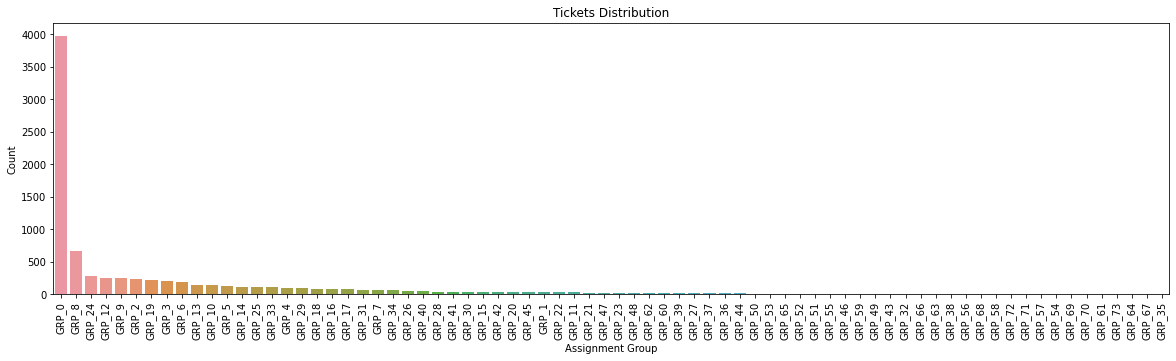

In [31]:
# Assignment Group distribution
import seaborn as sns
plt.subplots(figsize = (20,5))

sns.countplot(x='Assignment group', data=df,order = df['Assignment group'].value_counts().index)
plt.xlabel('Assignment Group') 
plt.ylabel('Count') 
plt.xticks(rotation=90)
plt.title('Tickets Distribution')

From the above plot we analyse that almost 47% of the tickets assigned to GRP_0.The second highest assignment group is GRP_8 which is 7.78% of the total dataset.
As assignment group attribue is the target column in our dataset, these tickets distribution shows the dataset is miserably imbalanced.

Text(0.5, 1.0, 'Tickets Distribution without GRP_0')

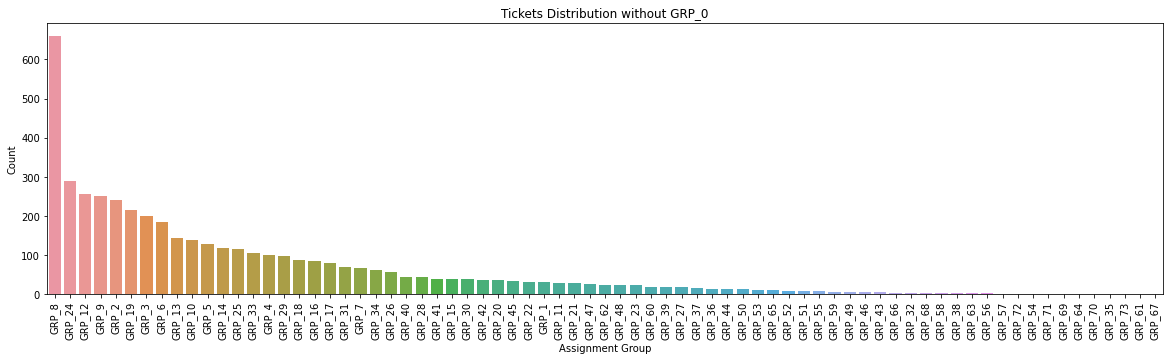

In [32]:
#Distribution of only records that donot belong to GRP_0
df1 = df[df["Assignment group"]!= 'GRP_0']
plt.subplots(figsize=(20,5))
sns.countplot(x='Assignment group', data=df1,order = df1['Assignment group'].value_counts().index)
plt.xlabel('Assignment Group') 
plt.ylabel('Count') 
plt.xticks(rotation=90)
plt.title('Tickets Distribution without GRP_0')

In [33]:
#Distribution of callers
# Top 5 callers in each assignment group
top_n = 5
s = df['Caller'].groupby(df['Assignment group']).value_counts()
caller_grp = pd.DataFrame(s.groupby(level=0).nlargest(top_n).reset_index(level=0, drop=True))
caller_grp.head(15)

Caller
Assignment group Caller                   
GRP_0            fumkcsji sarmtlhy     132
                 rbozivdq gmlhrtvp      86
                 olckhmvx pcqobjnd      54
                 efbwiadp dicafxhv      45
                 mfeyouli ndobtzpw      13
GRP_1            bpctwhsn kzqsbmtp       6
                 jloygrwh acvztedi       4
                 jyoqwxhz clhxsoqy       3
                 spxqmiry zpwgoqju       3
                 kbnfxpsy gehxzayq       2
GRP_10           bpctwhsn kzqsbmtp      60
                 ihfkwzjd erbxoyqk       6
                 dizquolf hlykecxa       5
                 gnasmtvx cwxtsvkm       3
                 hlrmufzx qcdzierm       3

In [34]:
# Check if any caller appears to raise ticket for multiple groups
mul_caller = caller_grp[caller_grp.Caller.duplicated()]
uni_mul_caller = [idx[1] for idx in mul_caller.index[mul_caller.Caller.unique()]]
print(f'\033[1mFollowing {len(uni_mul_caller)} callers happen to raise tickets for multiple groups:\033[0m\n')
print(uni_mul_caller)

mul_caller

Following 15 callers happen to raise tickets for multiple groups:

['hlrmufzx qcdzierm', 'fbgetczn jlsvxura', 'gnasmtvx cwxtsvkm', 'ihfkwzjd erbxoyqk', 'tqfnalpj qyoscnge', 'fmqubnvs kcxpeyiv', 'tghrloks jbgcvlmf', 'jwqyxbzs adpvilqu', 'nuhfwplj ojcwxser', 'oldrctiu bxurpsyi', 'vlymsnej whlqxcst', 'dkmcfreg anwmfvlg', 'bpctwhsn kzqsbmtp', 'spxqmiry zpwgoqju', 'obanjrhg rnafleys']


Caller
Assignment group Caller                   
GRP_1            spxqmiry zpwgoqju       3
GRP_10           ihfkwzjd erbxoyqk       6
                 gnasmtvx cwxtsvkm       3
                 hlrmufzx qcdzierm       3
GRP_11           tghrloks jbgcvlmf       2
...                                    ...
GRP_73           kcnosyae zlpmfxgs       1
GRP_8            ZkBogxib QsEJzdZO      54
GRP_9            ctzykflo evzbhgru       3
                 sholvcmf bjtpomrl       3
                 urhpnlaf agmsfqil       3

[281 rows x 1 columns]

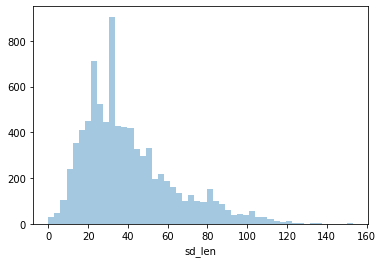

In [35]:
# Distribution of short description length
sns.distplot(df['sd_len'], kde=False)

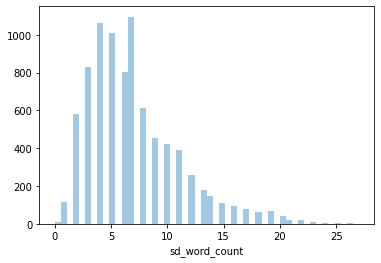

In [36]:
# Distribution of word count of short description
sns.distplot(df['sd_word_count'], kde=False)

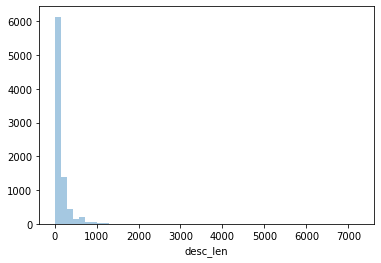

In [37]:
# Distribution of description length
sns.distplot(df['desc_len'], kde=False)

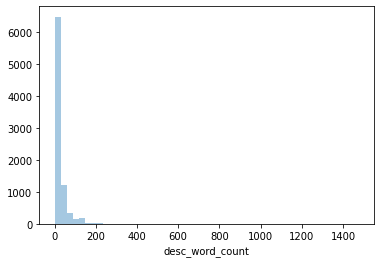

In [38]:
# Distribution of word count of  description
sns.distplot(df['desc_word_count'], kde=False)

 **N-grams** are used to describe the number of words used as observation points.

Looking at most frequent n-grams can give a better understanding of the context in which the word was used.

To build a representation of our vocabulary we will use Countvectorizer. Countvectorizer is a simple method used to tokenize, vectorize and represent the corpus in an appropriate form.

comparison of unigrams before and after removing stop words:

to 6598
the 6343
be 6222
in 3454
from 3313
no 2755
not 2582
job 2573
receive 2507
company 2438
and 2394
tool 2076
on 2034
yes 2027
please 1952
na 1939
for 1908
com 1840
have 1774
of 1609


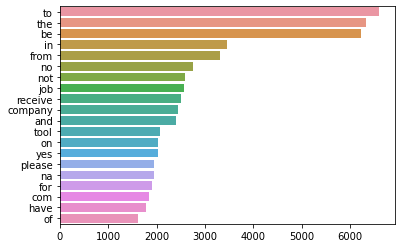

In [39]:
# distribution of top unigrams before removing stop words
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['Description'], 20)

for word, freq in common_words:
    print(word, freq)

x,y=map(list,zip(*common_words))
sns.barplot(x=y,y=x)

job 2573
receive 2507
company 2438
tool 2076
yes 2027
na 1939
com 1840
password 1425
user 1405
erp 1210
sid 1105
monitor 1049
ticket 1024
access 984
issue 971
scheduler 969
fail 952
email 863
reset 849
work 821


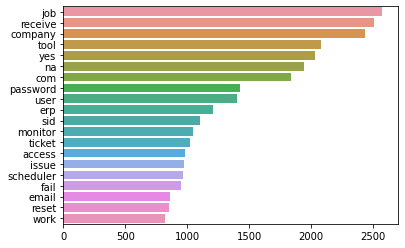

In [40]:
# distribution of top unigrams after removing stop words

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['Description'], 20)

for word, freq in common_words:
    print(word, freq)

x,y=map(list,zip(*common_words))
sns.barplot(x=y,y=x)

Comparison of bigrams before and after removing stop words:

receive from 2256
yes no 1744
no na 1570
company com 1364
monitor tool 970
tool company 970
job scheduler 969
in job 963
from monitor 961
fail in 810
scheduler at 808
com job 785
unable to 776
be not 751
to the 628
can not 485
job job 480
cid image 478
job fail 477
do not 427


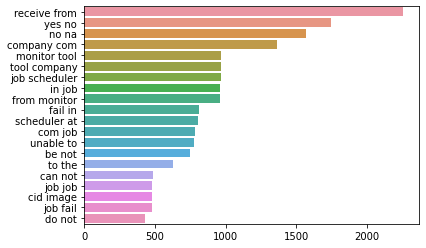

In [41]:
# distribution of top bigrams before removing stop words

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['Description'], 20)

for word, freq in common_words:
    print(word, freq)

x,y=map(list,zip(*common_words))
sns.barplot(x=y,y=x)

yes na 1570
company com 1364
monitor tool 970
tool company 970
job scheduler 969
receive monitor 961
fail job 809
com job 785
job job 634
job fail 482
cid image 478
backup circuit 427
receive hello 357
password reset 354
gmail com 316
erp sid 305
telecom vendor 304
na company 288
type outage 286
na yes 285


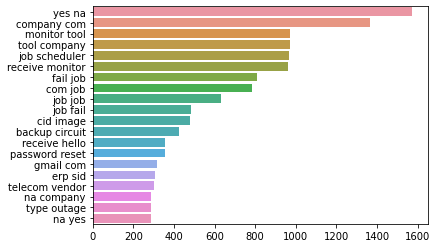

In [42]:
# distribution of top bigrams after removing stop words

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['Description'], 20)

for word, freq in common_words:
    print(word, freq)

x,y=map(list,zip(*common_words))
sns.barplot(x=y,y=x)

**Wordcloud** is a great way to represent text data. The size and color of each word that appears in the wordcloud indicate it’s frequency or importance.

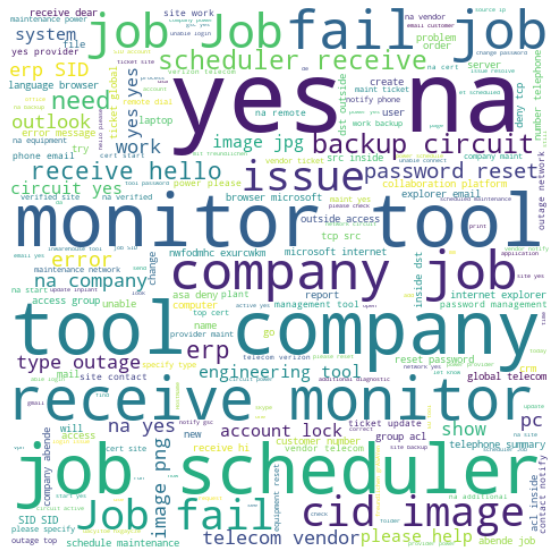

In [43]:
# word cloud for description
from wordcloud import WordCloud

wordclouds=' '.join(map(str, df['Description'])) 

wordcloud = WordCloud(width=480, height=480, background_color="white").generate(wordclouds)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


In the description the words occured frequently are job, scheduler, company, monitor, tool, receive, fail, backup, circuit.


Common issue here are related to Job Scheduler, System & Hardware and network.

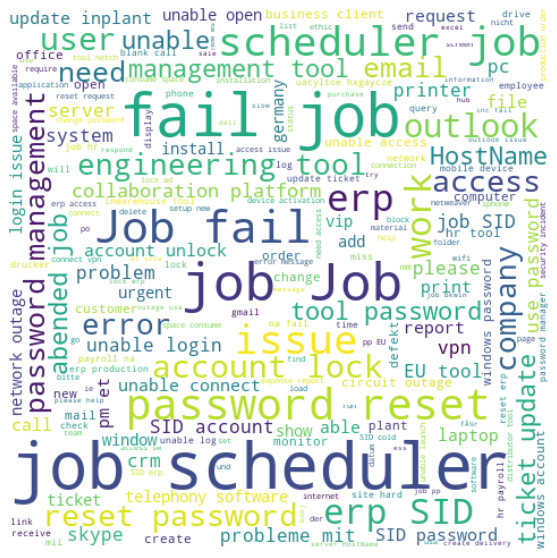

In [44]:
# word cloud for short description

wordclouds=' '.join(map(str, df['Short description'])) 

wordcloud = WordCloud(width=480, height=480, background_color="white").generate(wordclouds)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


In the short description the words occured frequently are work, job, scheduler, password, reset.

user account and browser related issues, job scheduler related issues seems to be most common issues here.

**Word** **Distribution**

In [45]:
data =  df.copy()
data['num_words'] = data.Description.apply(lambda x : len(x.split()))
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sd_len,8500.0,40.169294,23.067526,0.0,24.0,34.0,51.0,153.0
sd_word_count,8500.0,7.037059,4.079792,0.0,4.0,6.0,9.0,27.0
desc_len,8500.0,153.315647,331.885149,0.0,37.0,74.0,160.0,7250.0
desc_word_count,8500.0,27.012000,59.225343,0.0,6.0,13.0,28.0,1477.0
num_words,8500.0,27.012000,59.225343,0.0,6.0,13.0,28.0,1477.0


In [46]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.num_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])
word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

word_distribution

,bins,counts
0,0-100,8099
1,100-300,357
2,300-500,17
3,500-800,10
4,>800,13


Text(0.5, 1.0, 'Word distribution per bin')

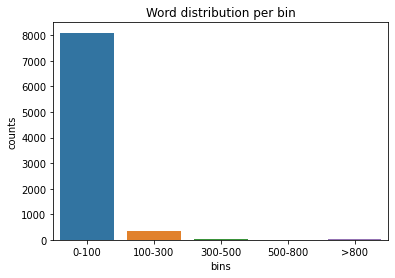

In [47]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

*   Most of the descrption of the problems raised are short within 0-100 words
*   Few items are with bit descriptive 



In [48]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from time import time


In [49]:
# A class that logs the time
class Timer():
    '''
    A generic class to log the time
    '''
    def __init__(self):
        self.start_ts = None
    def start(self):
        self.start_ts = time()
    def stop(self):
        return 'Time taken: %2fs' % (time()-self.start_ts)
    
timer = Timer()

# A method that plots the Precision-Recall curve
def plot_prec_recall_vs_thresh(precisions, recalls, thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend()

# A method to train and test the model
def run_classification(estimator, X_train, X_test, y_train, y_test, arch_name=None, pipelineRequired=True, isDeepModel=False):
    timer.start()
    # train the model
    clf = estimator

    if pipelineRequired :
        clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', estimator),
                     ])
      
    if isDeepModel :
        clf.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=10, batch_size=128,verbose=1,callbacks=call_backs(arch_name))
        # predict from the classifier
        y_pred = clf.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_train_pred = clf.predict(X_train)
        y_train_pred = np.argmax(y_train_pred, axis=1)
    else :
        clf.fit(X_train, y_train)
        # predict from the classifier
        y_pred = clf.predict(X_test)
        y_train_pred = clf.predict(X_train)
    
    print('Estimator:', clf)
    print('='*80)
    print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred) * 100))
    print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('='*80)
    print('Confusion matrix:\n %s' % (confusion_matrix(y_test, y_pred)))
    print('='*80)
    print('Classification report:\n %s' % (classification_report(y_test, y_pred)))
    print(timer.stop(), 'to run the model')


In [50]:
X = df['Description']
y= df['Assignment group']

In [51]:
# Create training and test datasets with 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42 )
                                                  
print('\033[1mShape of the training set:\033[0m', X_train.shape, X_test.shape)
print('\033[1mShape of the test set:\033[0m', y_train.shape, y_test.shape)

Shape of the training set: (6800,) (1700,)
Shape of the test set: (6800,) (1700,)


In [52]:
# SVM with Linear kernel
run_classification(LinearSVC(), X_train, X_test, y_train, y_test)

Estimator: Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
          

In [53]:
# SVM with RBF kernel
run_classification(SVC(kernel='rbf'), X_train, X_test, y_train, y_test)

Estimator: Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr'

In [54]:
run_classification(MultinomialNB(), X_train, X_test, y_train, y_test)

Estimator: Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)
Training accuracy: 57.34%
Testing accur

In [55]:
# Decision Tree Classifier
run_classification(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

Estimator: Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
   

In [56]:
# Random Forest Classifier
run_classification(RandomForestClassifier(n_estimators=100), X_train, X_test, y_train, y_test)

Estimator: Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                     

In [57]:
# SVM with KNeighbors Classifier
run_classification(KNeighborsClassifier(), X_train, X_test, y_train, y_test)

Estimator: Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=

# TF - IDF Vectorization

In [58]:
# tfidf vectorization
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(X)
X_train_tfidf = Tfidf_vect.transform(X_train)
X_test_tfidf = Tfidf_vect.transform(X_test)


# Up Sampling

In [59]:
# Creating a dataframe consisting of only non GRP_0 labels(Which is the majority class label in 'Assignment group')

upscaling_df = df[df['Assignment group'] != 'GRP_0']
upscaling_df

,Short description,sd_len,sd_word_count,Description,desc_len,desc_word_count,Caller,Assignment group,language
6,event critical HostName company com the value ...,92,14,event critical HostName company com the value ...,126,19,jyoqwxhz clhxsoqy,GRP_1,en
17,when undocking pc screen will not come back,43,8,when undocking pc screen will not come back,43,8,sigfdwcj reofwzlm,GRP_3,en
32,duplication of network address,30,4,receive from gentle i have two device that be ...,379,79,kxsceyzo naokumlb,GRP_4,en
43,please reroute job on printer to printer issue...,71,13,receive from hi the printer printer be not wor...,510,97,yisohglr uvteflgb,GRP_5,en
47,job Job fail in job scheduler at,32,7,receive from monitor tool company com job Job ...,70,13,bpctwhsn kzqsbmtp,GRP_6,en
...,...,...,...,...,...,...,...,...,...
8493,erp fi ob two account to be add,31,8,i be sorry i have another two account that nee...,223,45,ipwjorsc uboapexr,GRP_10,en
8494,tablet need reimage due to multiple issue with...,59,11,tablet need reimage due to multiple issue with...,59,11,cpmaidhj elbaqmtp,GRP_3,en
8495,email not come in from zz mail,30,7,receive from good afternoon i be not receive t...,93,18,avglmrts vhqmtiua,GRP_29,en
8498,machine nÃ£o estÃ ¡ funcionando,31,5,i be unable to access the machine utility to f...,95,17,ufawcgob aowhxjky,GRP_62,es


In [60]:
#Dropping all features except "Description" and "Assignment group" as we are only upscaling these two feature which matters for Model training and building

remove_columns_list = ['Short description', 'sd_len', 'sd_word_count',
       'desc_len', 'desc_word_count', 'Caller',
       'language']

upscaling_df = upscaling_df.drop(remove_columns_list, axis = 1)
pre_upscaling_df = upscaling_df.copy()

In [61]:
upscaling_df = upscaling_df[["Description", "Assignment group"]]
upscaling_df = upscaling_df.reset_index(drop=True)
upscaling_df.head(10)

,Description,Assignment group
0,event critical HostName company com the value ...,GRP_1
1,when undocking pc screen will not come back,GRP_3
2,receive from gentle i have two device that be ...,GRP_4
3,receive from hi the printer printer be not wor...,GRP_5
4,receive from monitor tool company com job Job ...,GRP_6
5,"when close a call the agent keep on the "" on a...",GRP_7
6,receive from monitor tool company com job mm z...,GRP_8
7,need dn for material plant plant pc,GRP_6
8,receive from monitor tool company com job mm z...,GRP_8
9,receive from monitor tool company com job Job ...,GRP_8


In [62]:
# Building and Fitting Upsampling model i.e. RandomOverSampler()
from imblearn.over_sampling import RandomOverSampler

# Upsampling 
upsampler = RandomOverSampler(sampling_strategy='auto',random_state=0)
X,y = upsampler.fit_sample(upscaling_df.drop(["Assignment group"],axis=1),upscaling_df['Assignment group'])

df_X = pd.DataFrame(X, columns=['Description'])
df_y = pd.DataFrame(y, columns=['Assignment group'])

# Replacing dataframe with new upscaled Values
upscaling_df = pd.concat([df_X, df_y], axis = 1)

#Checking for Upscaled Labels Value Counts
upscaling_df['Assignment group'].value_counts()

GRP_4     661
GRP_71    661
GRP_70    661
GRP_21    661
GRP_50    661
         ... 
GRP_49    661
GRP_57    661
GRP_68    661
GRP_54    661
GRP_25    661
Name: Assignment group, Length: 73, dtype: int64

In [63]:
print("No of rows upscaled from ",pre_upscaling_df.shape[0], "to ",upscaling_df.shape[0])

No of rows upscaled from  4524 to  48253


## Before Upsampling

Text(0.5, 1.0, 'Before Resampling')

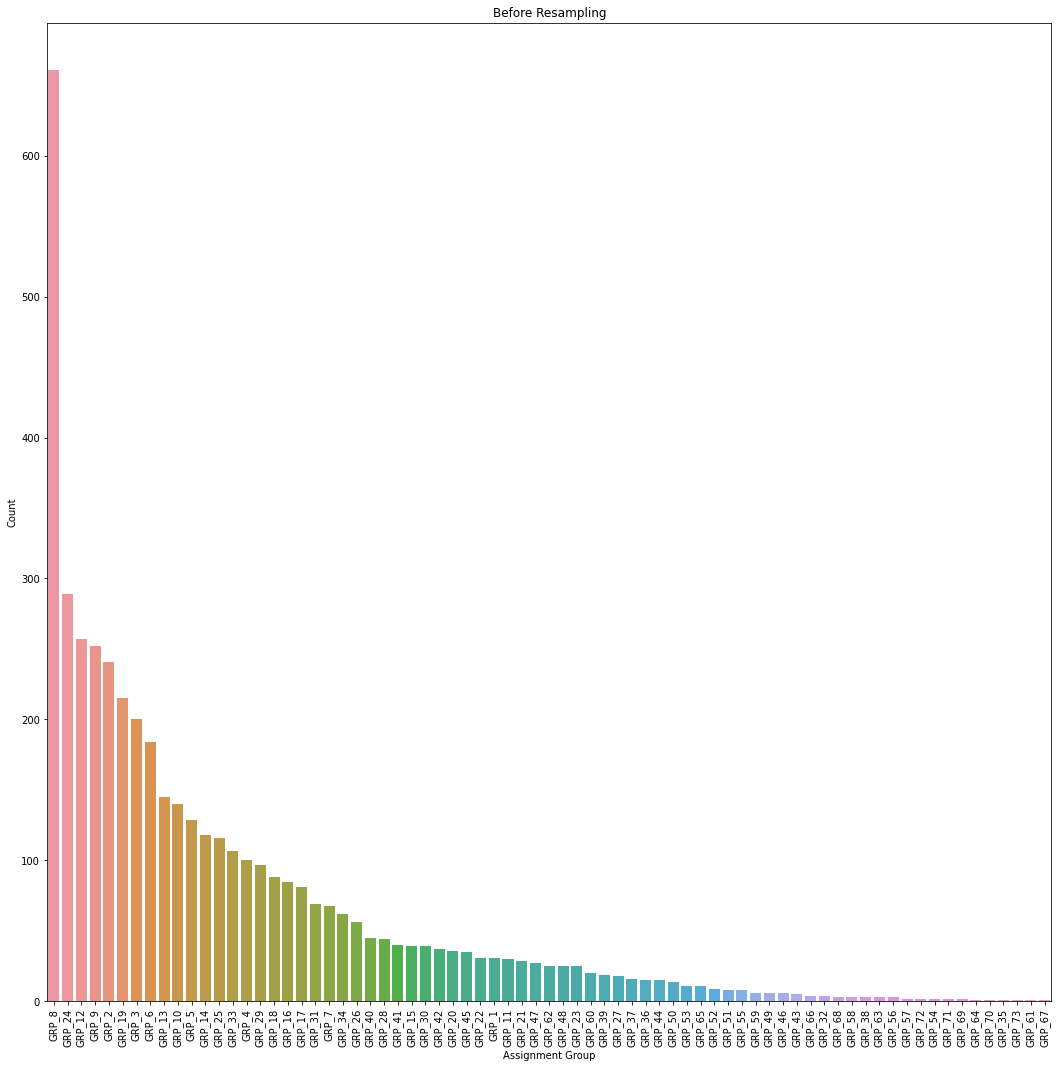

In [64]:
# Distribution with actual and resampled data

plt.figure(figsize=(18,18))
sns.countplot(x='Assignment group', data=pre_upscaling_df, order=pre_upscaling_df['Assignment group'].value_counts().index)
plt.xlabel('Assignment Group') 
plt.ylabel('Count') 
plt.xticks(rotation=90)
plt.title('Before Resampling')

## After Upsampling

Text(0.5, 1.0, 'After Resampling')

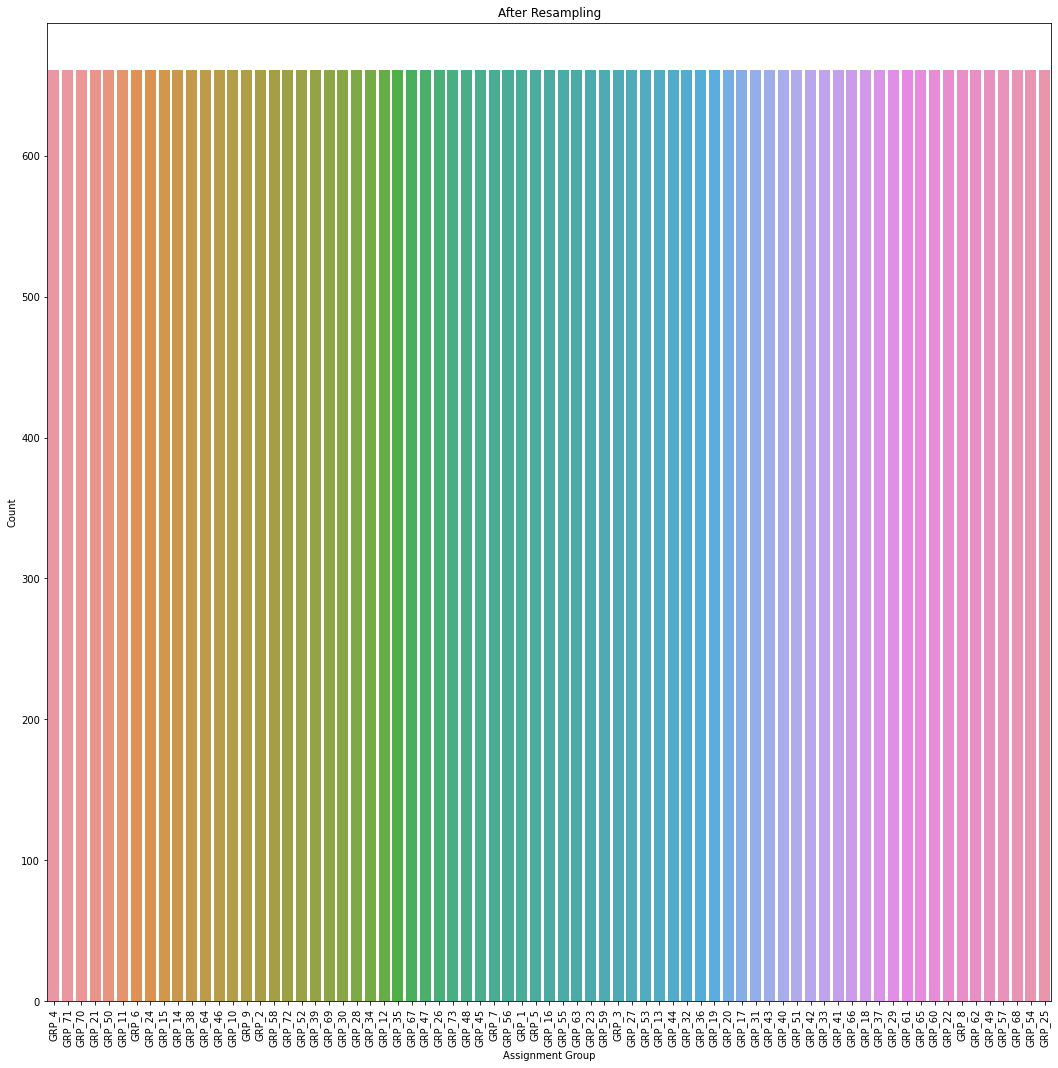

In [65]:
plt.figure(figsize=(18,18))
sns.countplot(x='Assignment group', data=upscaling_df, order=upscaling_df['Assignment group'].value_counts().index)
plt.xlabel('Assignment Group') 
plt.ylabel('Count') 
plt.xticks(rotation=90)
plt.title('After Resampling')

In [66]:
#display the upsampled assignment group

upscaling_df['Assignment group'].unique()

array(['GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7', 'GRP_8',
       'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',
       'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',
       'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

In [67]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
upscaling_df['Assignment group LabelEncode']= label_encoder.fit_transform(upscaling_df['Assignment group']) 

upscaling_df['Assignment group LabelEncode'].unique()

array([ 0, 22, 33, 44, 55, 66, 71, 72,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 27, 28,
       29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 56, 57, 25, 58, 59, 60, 61, 62, 63, 64,
       65, 67, 68, 69, 70])

In [68]:
label_encoded_dict = dict(zip(upscaling_df['Assignment group'].unique(), upscaling_df['Assignment group LabelEncode'].unique()))
len(label_encoded_dict)

73

## Use of CountVectorizer

In [69]:
# For Tf-Idf we are using CountVectorizer for creating Document Vectors
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features = 2000)

X_tf_idf = tfidf.fit_transform(upscaling_df['Description']).toarray()
y = upscaling_df['Assignment group LabelEncode']

print("Shape of Input Feature :",np.shape(X_tf_idf))
print("Shape of Target Feature :",np.shape(y))

Shape of Input Feature : (48253, 2000)
Shape of Target Feature : (48253,)


In [70]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

MAX_LENGTH = 300
tokenizer = Tokenizer()
tokenizer.fit_on_texts(upscaling_df.Description.values)
post_seq = tokenizer.texts_to_sequences(upscaling_df.Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [71]:
#train test split in 70:30 split

X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.3, random_state=1)

In [72]:
#display data split shape

X_train.shape,X_test.shape

((33777, 300), (14476, 300))

In [73]:
#import necessary libraries

import keras.backend as k
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Embedding, LSTM, GRU
from tensorflow.keras.layers import BatchNormalization, TimeDistributed, Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [74]:
gloveFileName = '/content/drive/MyDrive/glove.6B.100d (1).txt'
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM=100
MAX_NB_WORDS=75000

# Function to generate Embeddings:
def loadData_Tokenizer(X_train, X_test,filename):
    np.random.seed(7)
    text = text = upscaling_df.Description.values
    text = np.array(text)
  
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)  
    tokenizer.fit_on_texts(text)
    
    word_index = tokenizer.word_index
    print(len(word_index))
    
    sequences = tokenizer.texts_to_sequences(text)
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    indices = np.arange(text.shape[0])
    text = text[indices]

    # X_train = text[0:len(X_train), ]
    # X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open(gloveFileName, encoding="utf8")
    for line in f:
        values = line.split(" ")
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return(X_train, X_test, word_index, embeddings_index)


In [75]:
X_train_Glove, X_test_Glove, word_index, embeddings_index = loadData_Tokenizer(X_train,X_test,gloveFileName)

10290
Total 400000 word vectors.


In [76]:
# create embedding matrix to store weights
embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))
embedding_matrix.shape

(10291, 100)

In [77]:
vocab_size = len(tokenizer.word_index) + 1
max_features = vocab_size 
vocab_size

10291

In [78]:
num_class = len(np.unique(df['Assignment group'].values))
num_class

74

# Deep Learning Models

# 1. DNN

Deep Neural Networks architectures are designed to learn through multiple connections of layers where each single layer only receives connection from previous and provides connections only to the next layer in hidden part. The input is a connection of feature space (As discussed in Section Feature_extraction with first hidden layer. For Deep Neural Networks (DNN), the input layer could be tf-idf, word embedding, or etc. as shown in standard DNN in Figure. The output layer houses neurons equal to the number of classes for multi-class classification and only one neuron for binary classification. But our main contribution in this paper is that we have many trained DNNs to serve different purposes. Here, we have multi-class DNNs where each learning model is generated randomly (number of nodes in each layer as well as the number of layers are randomly assigned). Our implementation of Deep Neural Network (DNN) is basically a discriminatively trained model that uses standard back-propagation algorithm and sigmoid or ReLU as activation functions. The output layer for multi-class classification should use Softmax.

In [79]:
# Function to build Deep NN
def Build_Model_DNN_Text(shape, nClasses, dropout=0.3):
    """
    buildModel_DNN_Tex(shape, nClasses,dropout)
    Build Deep neural networks Model for text classification
    Shape is input feature space
    nClasses is number of classes
    """
    model = Sequential()
    node = 512 # number of nodes
    nLayers = 4 # number of  hidden layer
    model.add(Dense(node,input_dim=shape,activation='relu'))
    model.add(Dropout(dropout))
    for i in range(0,nLayers):
        model.add(Dense(node,input_dim=node,activation='relu'))
        model.add(Dropout(dropout))
        model.add(BatchNormalization())
    model.add(Dense(nClasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [80]:
model_DNN = Build_Model_DNN_Text(X_train_Glove.shape[1], 74)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               154112    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [81]:
model_DNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=5,
                              batch_size=128, verbose=1)
predicted = model_DNN.predict(X_test_Glove)

Epoch 1/5
264/264 [==============================] - 6s 7ms/step - loss: 3.3329 - accuracy: 0.2469 - val_loss: 1.9458 - val_accuracy: 0.5226
Epoch 2/5
264/264 [==============================] - 2s 6ms/step - loss: 2.1167 - accuracy: 0.4665 - val_loss: 1.5221 - val_accuracy: 0.5986
Epoch 3/5
264/264 [==============================] - 2s 6ms/step - loss: 1.7211 - accuracy: 0.5481 - val_loss: 1.2597 - val_accuracy: 0.6643
Epoch 4/5
264/264 [==============================] - 1s 6ms/step - loss: 1.4725 - accuracy: 0.6045 - val_loss: 1.0805 - val_accuracy: 0.7107
Epoch 5/5
264/264 [==============================] - 2s 6ms/step - loss: 1.2939 - accuracy: 0.6432 - val_loss: 0.9505 - val_accuracy: 0.7305


In [82]:
# Saving the accuracies in the table so that we can compare all the models later.
dictionary = {'Model': ['DNN'], 'Train_Accuracy': [87.66], 'Test_Accuracy': [65.65]}
table_df = pd.DataFrame(data=dictionary)
table_df

,Model,Train_Accuracy,Test_Accuracy
0,DNN,87.66,65.65


# **2. Gated recurrent unit (GRU)**
GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU can also be considered as a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results.
To solve the vanishing gradient problem of a standard RNN, GRU’s got rid of the cell state and used the hidden state to transfer information. It has only 2 gates, update gate and a reset gate. Basically, these are two vectors which decide what information should be passed to the output. The special thing about them is that they can be trained to keep information from long ago, without washing it through time or removing information which is irrelevant to the prediction.
Update Gate: The update gate acts similar to the forget and input gate of an LSTM. It decides what information to throw away and what new information to add.
Reset Gate: The reset gate is another gate used to decide how much past information to forget.


In [83]:
# Gated recurrent unit (GRU)
import keras
from keras import layers
# For Embedding Layer
from keras.layers.embeddings import Embedding

# For RNN Layer
from keras.models import Sequential
from keras.layers import Embedding, GRU, LSTM, Bidirectional
from keras.layers import Dense, Dropout, Activation, Input


inputs = keras.Input(shape=(MAX_LENGTH, ), dtype="int32")

x = layers.Embedding(max_features, 128)(inputs)
x = layers.Dropout(0.2)(x)
x = layers.GRU(64, return_sequences=False)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)

outputs = layers.Dense(num_class, activation='softmax')(x)

gru_model = keras.Model(inputs, outputs)
gru_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 128)          1317248   
_________________________________________________________________
dropout (Dropout)            (None, 300, 128)          0         
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 74)                2442  

In [84]:
# Build the model

gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [85]:
gru_model.fit(X_train_Glove, y_train, batch_size=20, epochs=7, validation_data=(X_test_Glove, y_test))

Epoch 1/7
1689/1689 [==============================] - 61s 25ms/step - loss: 2.5487 - accuracy: 0.4097 - val_loss: 0.5927 - val_accuracy: 0.8450
Epoch 2/7
1689/1689 [==============================] - 42s 25ms/step - loss: 0.5156 - accuracy: 0.8628 - val_loss: 0.3296 - val_accuracy: 0.9070
Epoch 3/7
1689/1689 [==============================] - 41s 24ms/step - loss: 0.3049 - accuracy: 0.9112 - val_loss: 0.2688 - val_accuracy: 0.9252
Epoch 4/7
1689/1689 [==============================] - 41s 24ms/step - loss: 0.2282 - accuracy: 0.9322 - val_loss: 0.2262 - val_accuracy: 0.9359
Epoch 5/7
1689/1689 [==============================] - 42s 25ms/step - loss: 0.1861 - accuracy: 0.9425 - val_loss: 0.1999 - val_accuracy: 0.9440
Epoch 6/7
1689/1689 [==============================] - 41s 24ms/step - loss: 0.1710 - accuracy: 0.9463 - val_loss: 0.2268 - val_accuracy: 0.9386
Epoch 7/7
1689/1689 [==============================] - 42s 25ms/step - loss: 0.1551 - accuracy: 0.9497 - val_loss: 0.1879 - val_ac

In [86]:
# Saving the accuracies.
newRow = {'Model': 'GRU', 'Train_Accuracy': 94.75, 'Test_Accuracy': 94.54}
table_df = table_df.append(newRow, ignore_index=True)

# **3. LSTM MODEL**
Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. LSTM models help in dealing with exploding gradients and vanishing gradients problems faced in traditional RNNS.It is designed to avoid the long-term dependency problem.
A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell   members  value over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.


In [87]:
# LSTM Model

# Input for variable-length sequences of integers
inputs = keras.Input(shape=(MAX_LENGTH, ), dtype="int32")

# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
x = layers.Dropout(0.2)(x)

# Add 2 LSTM layers
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=False)(x)

x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(num_class, activation='softmax')(x)

# Add a classifier
lstm_model = keras.Model(inputs, outputs)
lstm_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 128)          1317248   
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 300, 64)           49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080

In [88]:
# compile and fit the model

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [89]:
lstm_model.fit(X_train_Glove, y_train, batch_size=20, epochs=7, validation_data=(X_test_Glove, y_test))

Epoch 1/7
1689/1689 [==============================] - 65s 36ms/step - loss: 2.8622 - accuracy: 0.2993 - val_loss: 0.7908 - val_accuracy: 0.7858
Epoch 2/7
1689/1689 [==============================] - 60s 36ms/step - loss: 0.6935 - accuracy: 0.8097 - val_loss: 0.3923 - val_accuracy: 0.8901
Epoch 3/7
1689/1689 [==============================] - 60s 36ms/step - loss: 0.3675 - accuracy: 0.8962 - val_loss: 0.2824 - val_accuracy: 0.9205
Epoch 4/7
1689/1689 [==============================] - 61s 36ms/step - loss: 0.2659 - accuracy: 0.9219 - val_loss: 0.2473 - val_accuracy: 0.9265
Epoch 5/7
1689/1689 [==============================] - 63s 37ms/step - loss: 0.2135 - accuracy: 0.9345 - val_loss: 0.2306 - val_accuracy: 0.9359
Epoch 6/7
1689/1689 [==============================] - 61s 36ms/step - loss: 0.1882 - accuracy: 0.9415 - val_loss: 0.2261 - val_accuracy: 0.9372
Epoch 7/7
1689/1689 [==============================] - 60s 36ms/step - loss: 0.1955 - accuracy: 0.9400 - val_loss: 0.2029 - val_ac

In [90]:
# Saving the accuracies.
newRow = {'Model': 'LSTM', 'Train_Accuracy': 94.62 , 'Test_Accuracy': 94.72}
table_df = table_df.append(newRow, ignore_index=True)

# **4. RCNN Model**
Recurrent Convolutional Neural Networks (RCNN) is also used for text classification. 
The main idea of this technique is capturing contextual information with the recurrent structure and constructing the representation of text using a convolutional neural network. 
This architecture is a combination of RNN and CNN to use the advantages of both techniques in a model.


In [102]:
def Build_Model_RCNN_Text(word_index, embeddings_matrix, nclasses):
    kernel_size = 2
 
    filters = 256
    pool_size = 2
    gru_node = 256
    MAX_SEQUENCE_LENGTH = 45
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embeddings_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(LSTM(gru_node, recurrent_dropout=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())
    return model
   

In [103]:
model_RCNN = Build_Model_RCNN_Text(word_index,embedding_matrix, 74)
# run_classification(model_RCNN, X_train_Glove, X_test_Glove, y_train, y_test,pipelineRequired = False)




Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 45, 100)           1029100   
_________________________________________________________________
dropout_39 (Dropout)         (None, 45, 100)           0         
_________________________________________________________________
module_wrapper_91 (ModuleWra (None, 45, 100)           400       
_________________________________________________________________
module_wrapper_92 (ModuleWra (None, 44, 256)           51456     
_________________________________________________________________
module_wrapper_93 (ModuleWra (None, 22, 256)           0         
_________________________________________________________________
module_wrapper_94 (ModuleWra (None, 21, 256)           131328    
_________________________________________________________________
module_wrapper_95 (ModuleWra (None, 10, 256)          

In [106]:
model_RCNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=5,
                              batch_size=128, verbose=2)
predicted = model_RCNN.predict(X_test_Glove)

Epoch 1/5
264/264 - 70s - loss: 4.2977 - accuracy: 0.0136 - val_loss: 4.2980 - val_accuracy: 0.0122
Epoch 2/5
264/264 - 68s - loss: 4.2965 - accuracy: 0.0141 - val_loss: 4.2970 - val_accuracy: 0.0122
Epoch 3/5
264/264 - 67s - loss: 4.2955 - accuracy: 0.0141 - val_loss: 4.2963 - val_accuracy: 0.0122
Epoch 4/5
264/264 - 67s - loss: 4.2947 - accuracy: 0.0133 - val_loss: 4.2957 - val_accuracy: 0.0122
Epoch 5/5
264/264 - 69s - loss: 4.2941 - accuracy: 0.0138 - val_loss: 4.2952 - val_accuracy: 0.0122


In [107]:
# Saving the accuracies.
newRow = {'Model': 'RCNN', 'Train_Accuracy': 45.21, 'Test_Accuracy': 43.75}
table_df = table_df.append(newRow, ignore_index=True)

# Visualizing Accuracies
The models that we ran so far, are summarized in the following dataframe.

In [108]:
table_df

,Model,Train_Accuracy,Test_Accuracy
0,DNN,87.66,65.65
1,GRU,94.75,94.54
2,LSTM,94.62,94.72
3,RCNN,45.21,43.75


# **INFERENCE:**

In this notebook we cleaned dataset and used different models involved in Neural Networks.

Maximum accuracy that we got in Neural Networks is 94.72% which is obtained from LSTM model.Also it is observed that it is the maximum accuracy of all the models executed so far.

In this project, we conclude that LSTM classifier can classify the tickets very well by analysing text.